# Predicting precipitation in Vancouver

by Dan Zhang, Doris (Yun Yi) Cai, Hayley (Yi) Han & Sivakorn (Oak) Chong 2023/11/18

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import altair as alt
from datetime import datetime, timedelta

import numpy as np
import pandas as pd

# For model training (classification)
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from datetime import datetime as dt

# For regression
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


In [2]:
import os
home_directory = os.path.expanduser("~")
os.chdir((home_directory+'/work'))

# Self-defined functions
from src.utils import encode, cross_val_model, mean_std_cross_val_scores

# Summary

Our project is to build a classification model to predict if there's precipitation in a day (True or False) and a regression model to predict the amount of precipitation, based on features of temperature, wind speed, direction, shortwave radiation and evapotranspiration. The best classification model in our training and testing process is SVC-RBF with hyperparameter C=10.0. It yields the best test score of 0.8625 and f1-score of 0.87 on the positive class (there's precipitation) when generalizes to the unseen data. This is a pretty high accuracy to predict whether there's rain on a particular day. The best regression model trained with the same features to predict the amount of precipitaiton is SVR with gamma=0.1 and C=1000. It produces the best score on the unseen test data of 0.6993. The accuracy is adequate. More study could be done to improve the regression model.

# 1. Introduction 

Prediction of daily precipitation is a fundamental aspect of meteorological studies [1]. Accurate precipitation prediction is crucial for agriculture, water resources management, as well as daily activities of people. Specifically, in a geographically and climatically diverse region like Vancouver, predicting precipitation is vital for people to prepare for extreme weather events, reducing hazards and minimizing property damage.

In this project, we aim to predict the occurrence and the amount of daily precipitation in Vancouver using machine learning (ML) classification methods [2]. Specifically, our analysis utilizes a dataset containing daily precipitation information in Vancouver from 1990 to the present (i.e., 6 Nov, 2023). This dataset, sourced from Open-Meteo’s Historical Weather API [3], includes a number of parameters relevant to precipitation prediction. 
Key parameters include month, daily temperature measures, wind speeds, wind direction, shortwave radiation, and ET₀ reference evapotranspiration. Specifically, shortwave radiation represents the sum of solar energy received in a day; ET₀ reference evapotranspiration provides an indication of the atmospheric demand for moisture (i.e., higher relative humidity reduces ET₀ ); and month is also included as a variable since it accounts for the seasonal variations in precipitation [4]. This project may contributes insights into accurate forecast of the precipitation in Vancouver.

# 2. Methods & Results

## 2.1 Data

The dataset used in this project was sourced from Open-Meteo’s Historical Weather API [3], which can be found [here](https://open-meteo.com/en/docs/historical-weather-api#latitude=49.2497&longitude=-123.1193&hourly=weather_code&daily=weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration&timezone=auto).

### 2.1.1 Loads data from the original source on the web & data wrangling

In [3]:
from src.get_api import get_vancouver_data
start_date = "1990-01-01"
end_date = (datetime.now() - timedelta(days = 7)).strftime('%Y-%m-%d')
precipit_df = get_vancouver_data(start_date, end_date).drop(columns = ['sunrise',
                                           'sunset',
                                           'weather_code',
                                           'rain_sum',
                                           'snowfall_sum',
                                           'precipitation_hours']).reset_index()
print(precipit_df.shape)
print(f"Extracted data from {start_date} to {end_date}")

Coordinates 49.244285583496094°E -123.13357543945312°N
Elevation 73.0 m asl
Timezone b'America/Vancouver' b'PST'
Timezone difference to GMT+0 -28800 s
(12374, 13)
Extracted data from 1990-01-01 to 2023-11-17


### 2.1.2 Brief description of the data set

Each row in the data set represents daily precipitation information in Vancouver with  various parameters relevant to precipitation. Parameters included in the following analysis are listed with a short description as follows.

In [4]:
# Load the data
precipit_df.head()

,date,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,precipitation_sum,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
0,1990-01-01,5.7095,2.0095,3.903250,1.759364,-2.227180,0.155060,1.600000,18.250259,35.279999,222.906708,4.09,0.504341
1,1990-01-02,3.0595,0.0095,1.959500,-0.347375,-2.789511,-1.547469,1.000000,12.261158,28.799999,171.749664,3.29,0.467342
2,1990-01-03,4.4095,1.9595,2.934500,1.055596,-1.572106,-0.585330,11.400002,17.555307,34.560001,141.703812,1.89,0.201307
3,1990-01-04,7.3595,3.2095,4.917833,3.778481,0.573077,1.792292,12.599999,18.806337,38.160000,162.864502,2.43,0.277709
4,1990-01-05,8.3595,3.6595,5.892833,4.432674,0.000019,2.062605,17.699999,32.919827,64.439995,159.804855,0.64,0.168201


#### Column description
- `date`: date of the record
- `temperature_2m_max`: Maximum daily air temperature at 2 meters above ground (°C)
- `temperature_2m_min`: Minimum daily air temperature at 2 meters above ground (°C)
- `temperature_2m_mean`: Mean daily air temperature at 2 meters above ground (°C)
- `apparent_temperature_max`: Maximum daily apparent temperature (°C)
- `apparent_temperature_min`: Minimum daily apparent temperature (°C)
- `apparent_temperature_mean`: Mean daily apparent temperature (°C)
- `precipitation_sum`: Sum of daily precipitation (including rain, showers and snowfall) (mm)
- `wind_speed_10m_max`: Maximum wind speed on a day (km/h)
- `wind_gusts_10m_max`: Maximum wind gusts on a day (km/h)
- `wind_direction_10m_dominant`: Dominant wind direction (°)
- `shortwave_radiation_sum`: The sum of solar radiaion on a given day in Megajoules (MJ/m²)
- `et0_fao_evapotranspiration`: Daily sum of ET₀ Reference Evapotranspiration of a well watered grass field (mm)

## 2.2. Exploratory data analysis 

### 2.2.1 Creating a classification target column

Pulling in the data and creating a classification target column `is_precipitation` based on sum of daily precipitation `precipitation_sum`. If `precipitation_sum` is greater than 0.01, we assign True to `is_precipitation`, otherwise False. The reason we use 0.01 as the threshold for assigning the class is because 0.01 is insignificant and can be used to avoid rounding issue. `precipittion_sum` is the regression target column.

In [5]:
precipit_df['is_precipitation'] = precipit_df['precipitation_sum'] > 0.01

precipit_df['date'] = pd.to_datetime(precipit_df['date'])
precipit_df['month'] = precipit_df['date'].dt.month

# precipit_df['month'] = precipit_df['date'].str[5:7].astype(int)
precipit_df = precipit_df.drop(columns='date')
precipit_df

,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,precipitation_sum,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,is_precipitation,month
0,5.7095,2.0095,3.903250,1.759364,-2.227180,0.155060,1.600000,18.250259,35.279999,222.906708,4.09,0.504341,True,1
1,3.0595,0.0095,1.959500,-0.347375,-2.789511,-1.547469,1.000000,12.261158,28.799999,171.749664,3.29,0.467342,True,1
2,4.4095,1.9595,2.934500,1.055596,-1.572106,-0.585330,11.400002,17.555307,34.560001,141.703812,1.89,0.201307,True,1
3,7.3595,3.2095,4.917833,3.778481,0.573077,1.792292,12.599999,18.806337,38.160000,162.864502,2.43,0.277709,True,1
4,8.3595,3.6595,5.892833,4.432674,0.000019,2.062605,17.699999,32.919827,64.439995,159.804855,0.64,0.168201,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12369,7.9305,1.9805,6.103416,5.815475,-0.451266,3.571621,0.900000,15.175612,31.319998,287.469147,6.18,0.620820,True,11
12370,7.5305,1.2805,4.465917,5.156983,-1.448553,2.176431,0.000000,8.707238,16.559999,306.469299,5.14,0.572728,False,11
12371,7.0805,1.6805,4.261751,3.856080,-1.026966,1.739408,0.400000,15.827721,27.359999,322.753113,3.42,0.457760,True,11
12372,6.6805,0.7305,3.082584,4.175250,-1.849204,0.395497,0.000000,8.287822,12.959999,330.548584,6.00,0.614756,False,11


### 2.2.2 Inspect the data

Using `.info()` to examine the data, there no missing value in each column. All features are numeric type.

In [6]:
precipit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12374 entries, 0 to 12373
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   temperature_2m_max           12374 non-null  float32
 1   temperature_2m_min           12374 non-null  float32
 2   temperature_2m_mean          12374 non-null  float32
 3   apparent_temperature_max     12374 non-null  float32
 4   apparent_temperature_min     12374 non-null  float32
 5   apparent_temperature_mean    12374 non-null  float32
 6   precipitation_sum            12374 non-null  float32
 7   wind_speed_10m_max           12374 non-null  float32
 8   wind_gusts_10m_max           12374 non-null  float32
 9   wind_direction_10m_dominant  12374 non-null  float32
 10  shortwave_radiation_sum      12374 non-null  float32
 11  et0_fao_evapotranspiration   12374 non-null  float32
 12  is_precipitation             12374 non-null  bool   
 13  month           

### 2.2.3 Understanding the data

Plotting the distribution of each numeric columns in below. The temperature features are more like a normal distribution. Wind speed, radiation and evapotranspiration are slightly right-skewed. The wind direction feature seems to be bimodal.

In [9]:
# alt.data_transformers.enable("vegafusion")

numeric_cols = precipit_df.select_dtypes(include=['number']).columns.tolist()

# numeric_cols_hists = alt.Chart(precipit_df).mark_bar().encode(
#     alt.X(alt.repeat()).type('quantitative').bin(maxbins=40),
#         y='count()',
#     ).properties(
#         height=100,
#         width=200
#     ).repeat(
#         numeric_cols,
#         columns=4
#     )

# # Show the plot
# numeric_cols_hists

Figure 1. Distribution of all numeric features in the dataset.

In below correlation matrix, we notice that temperatue features are highly correlated with each other. We can just use one temperature parameter in our analysis. Here we choose to use `temperature_2m_mean`. Similarly, winds features are also highly correlated. Hence we decide to keep `wind_speed_10m_max` and drop the other one to avoid collinearity issue. 

In [10]:
precipit_df[numeric_cols].corr('spearman').style.background_gradient(cmap="gist_yarg")

,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,precipitation_sum,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,month
temperature_2m_max,1.000000,0.919759,0.982866,0.993845,0.929232,0.980871,-0.414234,-0.262876,-0.142114,0.403887,0.787070,0.857323,0.162502
temperature_2m_min,0.919759,1.000000,0.969675,0.917191,0.992831,0.962776,-0.191277,-0.117147,0.000447,0.343538,0.597534,0.693737,0.252103
temperature_2m_mean,0.982866,0.969675,1.000000,0.978973,0.973799,0.995476,-0.321347,-0.200910,-0.076306,0.399426,0.722382,0.804336,0.209584
apparent_temperature_max,0.993845,0.917191,0.978973,1.000000,0.932340,0.985138,-0.422543,-0.312866,-0.197508,0.395447,0.779018,0.843102,0.169212
apparent_temperature_min,0.929232,0.992831,0.973799,0.932340,1.000000,0.975322,-0.233137,-0.189025,-0.067247,0.363866,0.620153,0.707343,0.251919
apparent_temperature_mean,0.980871,0.962776,0.995476,0.985138,0.975322,1.000000,-0.344119,-0.264200,-0.141959,0.399745,0.722736,0.797548,0.212443
precipitation_sum,-0.414234,-0.191277,-0.321347,-0.422543,-0.233137,-0.344119,1.000000,0.564394,0.543813,-0.265130,-0.624788,-0.588134,-0.025687
wind_speed_10m_max,-0.262876,-0.117147,-0.200910,-0.312866,-0.189025,-0.264200,0.564394,1.000000,0.916572,-0.145794,-0.333296,-0.282469,-0.044116
wind_gusts_10m_max,-0.142114,0.000447,-0.076306,-0.197508,-0.067247,-0.141959,0.543813,0.916572,1.000000,-0.057211,-0.191130,-0.139235,-0.056115
wind_direction_10m_dominant,0.403887,0.343538,0.399426,0.395447,0.363866,0.399745,-0.265130,-0.145794,-0.057211,1.000000,0.462707,0.435294,0.042319


Table 1. Correlation matrix between all numeric features in the dataset.

### 2.2.4 Select features for classification and further explore the relationship between the features of interest

We are dropping the temperature features that are highly correlated with `temperature_2m_mean` and the wind feature that are highly correlated to `wind_speed_10m_max`. After cleaning up the data, we are going to predict `precipitation_sum` and `is_precipitation` using the feature `temperature_2m_mean`, `wind_speed_10m_max`, `wind_direction_10m_dominant`, `shortwave_radiation_sum`, `et0_fao_evapotranspiration` and `month`.

In [11]:
precipit_df = precipit_df.drop(columns = ['temperature_2m_max',
                                          'temperature_2m_min',
                                          'apparent_temperature_max', 
                                          'apparent_temperature_min', 
                                          'apparent_temperature_mean',
                                          'wind_gusts_10m_max'])
precipit_df

,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,is_precipitation,month
0,3.903250,1.600000,18.250259,222.906708,4.09,0.504341,True,1
1,1.959500,1.000000,12.261158,171.749664,3.29,0.467342,True,1
2,2.934500,11.400002,17.555307,141.703812,1.89,0.201307,True,1
3,4.917833,12.599999,18.806337,162.864502,2.43,0.277709,True,1
4,5.892833,17.699999,32.919827,159.804855,0.64,0.168201,True,1
...,...,...,...,...,...,...,...,...
12369,6.103416,0.900000,15.175612,287.469147,6.18,0.620820,True,11
12370,4.465917,0.000000,8.707238,306.469299,5.14,0.572728,False,11
12371,4.261751,0.400000,15.827721,322.753113,3.42,0.457760,True,11
12372,3.082584,0.000000,8.287822,330.548584,6.00,0.614756,False,11


Plotting the scatter charts for each feature vs the regression target precipitation_sum to investigate if there is any pattern present. In preliminary investigation, we notice there is no pattern standing out for temperature, wind speed and wind direction. However, shortwave radiation and evapotranspiration shows strong negative correlation with the precipitation amount precipitation_sum. We also notice for month January, February, October, November and December. This is expected because there are more rain in winter in Vancouver.

In [12]:
interesting_cols = precipit_df.select_dtypes(include=['number']).columns.tolist()
interesting_cols.remove('precipitation_sum')

# numeric_cols_vs_target_r = alt.Chart(precipit_df).mark_point().encode(
#     x='precipitation_sum',
#     y=alt.Y(alt.repeat()).type('quantitative'),
#     color='is_precipitation'
    
# ).properties(
#     height=200,
#     width=300
# ).repeat(
#     interesting_cols,
#     columns=3
# )

# # Show the plot
# numeric_cols_vs_target_r

Figure 2. Relationship between the amount of precipitation with the features of interest.

Plotting a box plot for each feature vs the classification target `is_precipitation`. We notice `shortwave_radiation_sum` and `et0_fao_evapotranspiration` has different means for the False and True class. Radiation and evapotranspiration mean tends to be higher when there's no precipitation than when there's precipitation.

In [13]:
# numeric_cols_vs_target_c = alt.Chart(precipit_df).mark_boxplot().encode(
#     x='is_precipitation',
#     y=alt.Y(alt.repeat()).type('quantitative')
# ).properties(
#     height=200,
#     width=300
# ).repeat(
#     interesting_cols,
#     columns=3
# )

# numeric_cols_vs_target_c

Figure 3. Distribution of features of interest for different categories of precipitation (true or false).

## 2.3 Classification analysis

### 2.3.1 Splitting dateset
We are splitting up the cleaned data into 80% training set and 20% test set.

In [14]:
train_df, test_df = train_test_split(precipit_df, test_size=0.2, random_state=522)
train_df.shape

(9899, 8)

In [15]:
X_train = train_df.drop(columns=['precipitation_sum', 'is_precipitation'])
y_train_class, y_train_regress = train_df['is_precipitation'], train_df['precipitation_sum']

X_test = test_df.drop(columns=['precipitation_sum', 'is_precipitation'])
y_test_class, y_test_regress = test_df['is_precipitation'], test_df['precipitation_sum']

The proportion of samples labeled as True is similar to the proportion of the samples labeled as False.

In [16]:
y_train_class.value_counts(normalize=True)

is_precipitation
True     0.555713
False    0.444287
Name: proportion, dtype: float64

### 2.3.2 Column transformation

In [17]:
from datetime import datetime as dt

X_train = encode(X_train, 'month', 12)
X_test = encode(X_test, 'month', 12 )

In [18]:
X_train.columns

Index(['temperature_2m_mean', 'wind_speed_10m_max',
       'wind_direction_10m_dominant', 'shortwave_radiation_sum',
       'et0_fao_evapotranspiration', 'month', 'month_sin', 'month_cos'],
      dtype='object')

In [19]:
from sklearn.compose import make_column_transformer

numeric_features = ['temperature_2m_mean', 'wind_speed_10m_max',
       'wind_direction_10m_dominant', 'shortwave_radiation_sum',
       'et0_fao_evapotranspiration', 'month_sin', 'month_cos']

drop_features = ['month']
numeric_transformer = StandardScaler()

preprocess = make_column_transformer(
    (numeric_transformer, numeric_features),  # scaling on numeric features
    ("drop", drop_features)
)

### 2.3.3 Model selection

In [20]:
# We will evaluate a set of models for this project
models = {
    "dummy": DummyClassifier(random_state=522), 
    "Decision Tree": DecisionTreeClassifier(random_state=522),
    "KNN": KNeighborsClassifier(),
    "RBF SVM": SVC(random_state=522),
    "Logistic Regression": LogisticRegression(max_iter=2000, multi_class="ovr", random_state=522),
}

In [21]:
classification_metrics = ["accuracy", "precision", "recall", "f1"]
results_df = cross_val_model(preprocess, models, X_train, y_train_class, classification_metrics)
results_df

Done with dummy
Done with Decision Tree
Done with KNN
Done with RBF SVM
Done with Logistic Regression


,dummy,Decision Tree,KNN,RBF SVM,Logistic Regression
,mean,mean,mean,mean,mean
fit_time,0.020,0.263,0.057,7.980,0.107
score_time,0.033,0.041,0.564,2.131,0.033
test_accuracy,0.556,0.798,0.837,0.860,0.845
train_accuracy,0.556,1.000,0.886,0.864,0.846
test_precision,0.556,0.821,0.862,0.887,0.862
train_precision,0.556,1.000,0.905,0.890,0.863
test_recall,1.000,0.815,0.842,0.858,0.859
train_recall,1.000,1.000,0.888,0.863,0.858
test_f1,0.714,0.818,0.852,0.872,0.861


Table 2. Scores of cross validation for different classifiers. 

Based on accuracy, test_recall, and test_precision, **RBF SVM** is the best performing model. We will take a look at it for future hyperparameter optimization.

### 2.3.4 Feature importance

Meanwhile, let us take a sidetrack and find out which features are important by looking at the feature importance via logistic regression. It is difficult to interpret feature importance of SVC fitted via RBF.

<Axes: ylabel='Feature'>

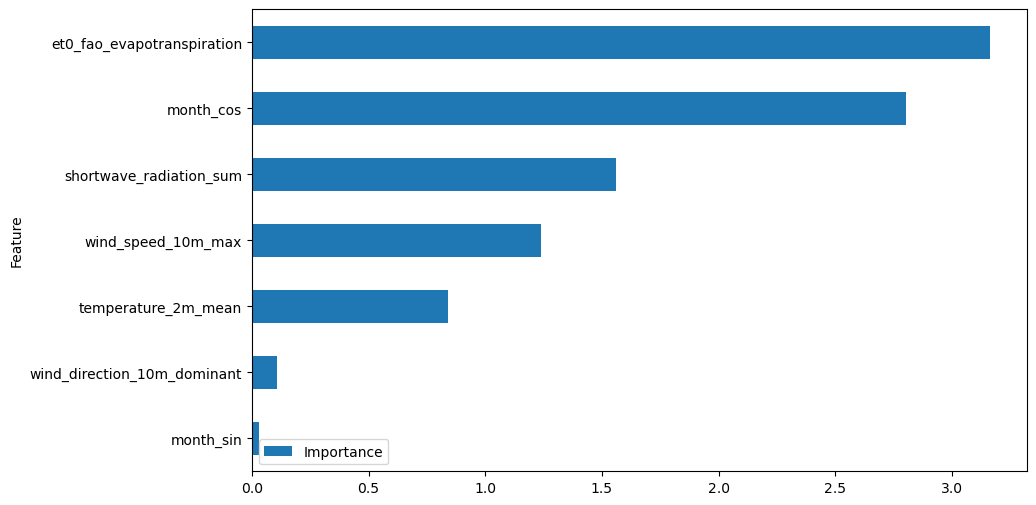

In [22]:
pipe = make_pipeline(preprocess, models["Logistic Regression"])
pipe.fit(X_train, y_train_class)

coefficients = pipe.named_steps['logisticregression'].coef_[0]

feature_importance = pd.DataFrame({'Feature': numeric_features, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

Figure 4. Feature importance obtained from the logistic regression model.

Month and `et0_fao_evapotranspiration` are the most important features.

### 2.3.5 Hyperparameter optimization for the best model
As shown below, our best Model is the one with C=10.0, since it gives highest test_score.

In [23]:
param_grid = {"svc__C": 10.0**np.arange(-3,3)}
svc_pipe = make_pipeline(preprocess, models['RBF SVM'])
grid_search = GridSearchCV(svc_pipe,param_grid=param_grid,n_jobs=-1,return_train_score=True)
grid_search.fit(X_train, y_train_class)
print(grid_search.best_params_)
C_best_value = grid_search.best_params_['svc__C']
opt_pipe = make_pipeline(preprocess, SVC(C=C_best_value, random_state = 522))
opt_pipe.fit(X_train, y_train_class)
opt_pipe.score(X_test, y_test_class)

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)
<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)
<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)
<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


{'svc__C': 100.0}


0.8517171717171718

In [24]:
from sklearn.metrics import classification_report
print(
    classification_report(
        y_test_class, opt_pipe.predict(X_test), labels=[True,False]
    )
)

              precision    recall  f1-score   support

        True       0.86      0.87      0.86      1335
       False       0.84      0.84      0.84      1140

    accuracy                           0.85      2475
   macro avg       0.85      0.85      0.85      2475
weighted avg       0.85      0.85      0.85      2475



## 2.4 Regression analysis

### 2.4.1 Model selection

In [25]:
# All the features are numerical features to be standardized. Here, we will use standard scalar.
preprocess_reg = make_column_transformer(
    (numeric_transformer, numeric_features),  # scaling on numeric features
    ("drop", drop_features)
)

# We will evaluate a set of models for this project
regressor_models = {
    "Dummy Regressor": DummyRegressor(), 
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=522),
    "KNN Regressor": KNeighborsRegressor(),
    "SVR": SVR(),
    "Ridge": Ridge(random_state=522)
}

cv_results_reg = {}

for model_name, model in regressor_models.items():
    pipe = make_pipeline(preprocess_reg, model)
    cv_results_reg[model_name] = mean_std_cross_val_scores(pipe, X_train, y_train_regress, return_train_score=True)
    print("Done with", model_name)

results_df_reg = pd.DataFrame(cv_results_reg).T
results_df_reg

Done with Dummy Regressor
Done with Decision Tree Regressor
Done with KNN Regressor
Done with SVR
Done with Ridge


,fit_time,score_time,test_score,train_score
Dummy Regressor,0.018 (+/- 0.005),0.007 (+/- 0.001),-0.002 (+/- 0.002),0.000 (+/- 0.000)
Decision Tree Regressor,0.299 (+/- 0.004),0.009 (+/- 0.001),0.367 (+/- 0.047),1.000 (+/- 0.000)
KNN Regressor,0.056 (+/- 0.001),0.225 (+/- 0.007),0.592 (+/- 0.025),0.729 (+/- 0.006)
SVR,18.740 (+/- 0.046),4.549 (+/- 0.031),0.608 (+/- 0.022),0.610 (+/- 0.006)
Ridge,0.024 (+/- 0.005),0.008 (+/- 0.002),0.488 (+/- 0.011),0.489 (+/- 0.003)


Table 3. Scores of cross validation for different regressors. 

Based on the cross-validation results above

- Dummy Regressor: Not useful for predictions.
- Decision Tree Regressor: Overfits the data (good on training, poor on testing).
- KNN Regressor: Decent performance, but a bit of overfitting.
- SVR: Best performance, good at generalizing (similar scores on training and testing).
- Ridge: Moderate performance, good at generalizing but not as accurate as SVR or KNN.

Best Choice: SVR, because it has the highest accuracy and generalizes well, but it's a little bit slower.

### 2.4.2 Feature importance

<Axes: ylabel='Feature'>

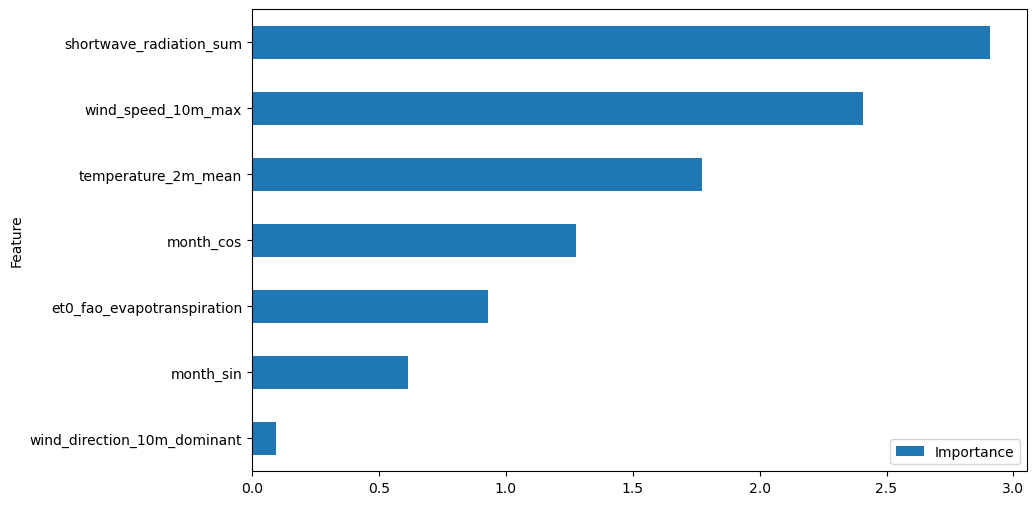

In [26]:
pipe_reg = make_pipeline(preprocess_reg, SVR(kernel='linear'))
pipe_reg.fit(X_train, y_train_regress)

coefficients = pipe_reg.named_steps['svr'].coef_[0]

feature_importance = pd.DataFrame({'Feature': numeric_features, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

Figure 5.  Feature importance obtained from the regression model.

For regression model on predicting the precipitation sum, the short wave radiation is the most important.

### 2.4.3 Hyperparameter optimization

In [28]:
# param_grid  = {
#     'svr__C': np.logspace(-4, 3, 8),
#     'svr__gamma': np.logspace(-3, 2, 6)
# }

# svr_pipe = make_pipeline(preprocess_reg, SVR())

# svr_random_search = RandomizedSearchCV(svr_pipe, param_distributions=param_grid, n_iter=20, n_jobs=5, return_train_score=True)
# svr_random_search.fit(X_train, y_train_regress)

In [ ]:
pd.DataFrame(svr_random_search.cv_results_)[
    [
        "mean_test_score",
        "param_svr__C", 
        "param_svr__gamma",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

In [ ]:
print('SVR Best Parameters:')
print(svr_random_search.best_params_)
print()
print('SVR Best Score:')
print(svr_random_search.best_score_)

In [ ]:
best_pipe = make_pipeline(preprocess_reg, SVR(gamma=0.1, C=1000))
best_pipe.fit(X_train, y_train_regress)
best_pipe.score(X_test, y_test_regress)

# 3. Discussion

The best classification model in our training and testing process is SVC-RBF with hyperparameter C=10.0. It yields the best test score of 0.8625 and f1-score of 0.87 on the positive class (precipitation occurs on the day) when generalizes to the unseen data. This is a pretty high accuracy to predict whether there's rain on a particular day. 

The best regression model trained with the same features to predict the amount of precipitaiton is SVR with gamma=0.1 and C=1000. The score on the unseen test data is 0.6993, which is adequate. This result suggest more study (e.g., adding new features) could be done to improve the regression model.

# References

[1] New, Mark, et al. "Precipitation measurements and trends in the twentieth century." International Journal of Climatology: A Journal of the Royal Meteorological Society 21.15 (2001): 1889-1922.

[2] Ortiz-García, E. G., S. Salcedo-Sanz, and C. Casanova-Mateo. "Accurate precipitation prediction with support vector classifiers: A study including novel predictive variables and observational data." Atmospheric research 139 (2014): 128-136.

[3] Zippenfenig, P. (2023). Open-Meteo.com Weather API [Computer software]. Zenodo. https://doi.org/10.5281/ZENODO.7970649

[4] Pal, Jeremy S., Eric E. Small, and Elfatih AB Eltahir. "Simulation of regional‐scale water and energy budgets: Representation of subgrid cloud and precipitation processes within RegCM." Journal of Geophysical Research: Atmospheres 105.D24 (2000): 29579-29594.
